# 7장. 자연어 처리를 위한 순환 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch07/07-rnn.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch07/07-rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
# # 노트북이 코랩에서 실행 중인지 체크합니다.
# import sys
# if 'google.colab' in sys.modules:
#     !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
#     !mkdir ../ch05
#     !mv sarcasm.json ../ch05

## 1. 순환 구조
단어의 등장 순서가 전체적인 의미를 결정하기도 한다.   
형용사는 명사의 의미를 추가하거나 바꿀 수 있다.   
-> 부가적인 접근이 필요: **순환** -> 순환신경망(RNN: recurrent neural network)
<br><br>
순환신경망(RNN)   
마치 피보나치 수열처럼, 모든 연산이 이전의 결과에 의존한다.   
<br>
<img src="RNN.PNG" width=500>

## 2. 순환을 언어로 확장하기
문장 내에서 서로 관련 있는 단어가 멀리 떨어져 있을 때   
- 기존 방식은 거리가 멀어질수록 앞선 단어가 미치는 영향이 줄어든다.   
- 따라서, RNN의 단기 기억이 더 길어져야 한다. : LSTM(Long Short-Term memory)

<LSTM의 구조>   
셀 상태(cell state)를 추가해, 기본 RNN을 향상시킨다.   
스텝 사이 뿐만 아니라, 시퀀스 전체에 걸쳐 문맥을 유지하도록 돕는다.   
그리고 각 스텝의 결과값 y는 **정방향 계산과 역방향 계산의 합** : 양방향 LSTM
<br><br>
<img src="LSTM.PNG" width=500>
<br><br>
장점: 단어의 감성을 더 잘 확인할 수 있다.   
단점: 많은 연산을 수행하므로 훈련 속도가 느리다.

## 3. RNN으로 텍스트 분류기 만들기
### 3-0. LSTM 사용하기

In [1]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

▼ 문장 데이터 전처리

In [3]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

c:\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [4]:
vocab_size = 20000
embedding_dim = 64
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [7]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),     # Bidirectional 층을 추가해 양방향 LSTM을 사용하도록 할 수 있다. 차원 수는 임베딩에 입력한 차원과 동일
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001,                      # 학습률 재설정
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,349,169
Trainable params: 1,349,169
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 34s 42ms/step - loss: 0.6892 - accuracy: 0.5551 - val_loss: 0.6844 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 32s 44ms/step - loss: 0.6840 - accuracy: 0.5596 - val_loss: 0.6804 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 32s 45ms/step - loss: 0.6807 - accuracy: 0.5596 - val_loss: 0.6767 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 34s 48ms/step - loss: 0.6755 - accuracy: 0.5596 - val_loss: 0.6702 - val_accuracy: 0.5702
Epoch 5/30
719/719 [==============================] - 34s 47ms/step - loss: 0.6658 - accuracy: 0.5641 - val_loss: 0.6580 - val_accuracy: 0.5810
Epoch 6/30
719/719 [==============================] - 34s 47ms/step - loss: 0.6477 - accuracy: 0.6250 - val_loss: 0.6367 - val_accuracy: 0.6622
Epoch 7/30
719/719 [==============================] - 34s 48ms/step - loss: 0.6186 - accuracy: 0.6877 - val_loss: 0.6100 - val_accuracy:

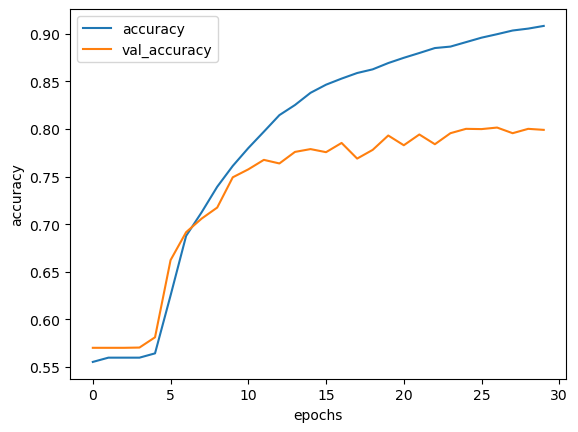

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

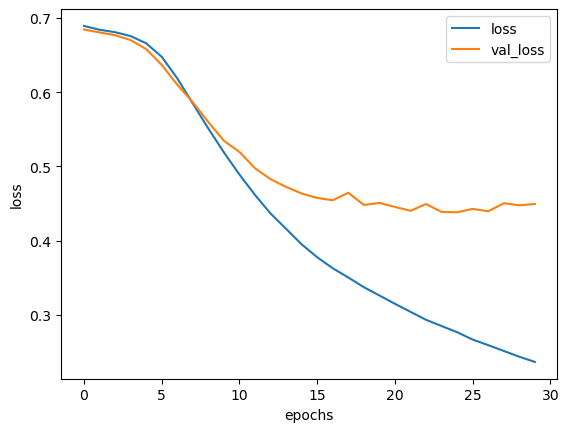

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### 3-1. 스태킹 LSTM
LSTM 층 쌓기

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),     # 마지막 이전 LSTM 층에 return_sequences=True 추가
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,447,985
Trainable params: 1,447,985
No

In [15]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 76s 98ms/step - loss: 0.6879 - accuracy: 0.5574 - val_loss: 0.6821 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 75s 104ms/step - loss: 0.6833 - accuracy: 0.5596 - val_loss: 0.6793 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 78s 108ms/step - loss: 0.6799 - accuracy: 0.5596 - val_loss: 0.6731 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 76s 106ms/step - loss: 0.6673 - accuracy: 0.5756 - val_loss: 0.6516 - val_accuracy: 0.6271
Epoch 5/30
719/719 [==============================] - 74s 103ms/step - loss: 0.6236 - accuracy: 0.6753 - val_loss: 0.5914 - val_accuracy: 0.7077
Epoch 6/30
719/719 [==============================] - 74s 103ms/step - loss: 0.5194 - accuracy: 0.7597 - val_loss: 0.5020 - val_accuracy: 0.7600
Epoch 7/30
719/719 [==============================] - 73s 101ms/step - loss: 0.4314 - accuracy: 0.8113 - val_loss: 0.4803 - val_acc

KeyboardInterrupt: 

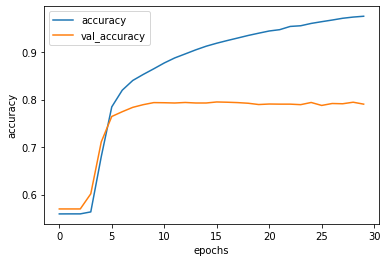

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

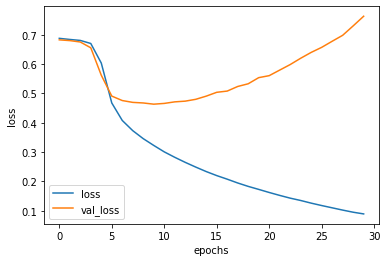

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

정확도는 좋지만, 검증 손실이 빠르게 높아진다. = 과대적합   
이 문제를 해결하기 위해 최적화 방법들을 적용해보자.

#### 3-1-1. 스태킹 LSTM 최적화하기

#### 3-1-1-1. 학습률 변경하기

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008,                         # 학습률 변경
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [20]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 24s 27ms/step - loss: 0.6891 - accuracy: 0.5510 - val_loss: 0.6839 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6841 - accuracy: 0.5596 - val_loss: 0.6805 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6816 - accuracy: 0.5596 - val_loss: 0.6774 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6766 - accuracy: 0.5600 - val_loss: 0.6707 - val_accuracy: 0.5735
Epoch 5/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6576 - accuracy: 0.6067 - val_loss: 0.6387 - val_accuracy: 0.6616
Epoch 6/30
719/719 [==============================] - 18s 25ms/step - loss: 0.6019 - accuracy: 0.6915 - val_loss: 0.5754 - val_accuracy: 0.7080
Epoch 7/30
719/719 [==============================] - 17s 24ms/step - loss: 0.5131 - accuracy: 0.7550 - val_loss: 0.5090 - val_accuracy:

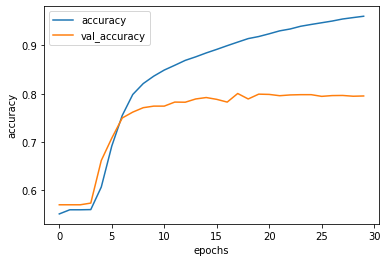

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

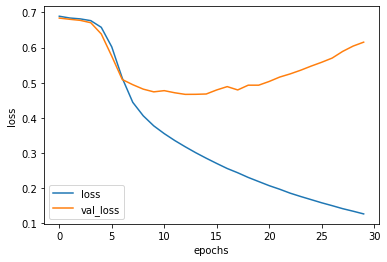

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

손실함수의 상승이 조금 덜해졌다.

#### 3-1-1-2. 드롭아웃 사용하기

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        embedding_dim, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [24]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 24s 26ms/step - loss: 0.6879 - accuracy: 0.5595 - val_loss: 0.6824 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6838 - accuracy: 0.5596 - val_loss: 0.6801 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6820 - accuracy: 0.5596 - val_loss: 0.6779 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6789 - accuracy: 0.5596 - val_loss: 0.6738 - val_accuracy: 0.5700
Epoch 5/30
719/719 [==============================] - 17s 24ms/step - loss: 0.6715 - accuracy: 0.5640 - val_loss: 0.6623 - val_accuracy: 0.6153
Epoch 6/30
719/719 [==============================] - 18s 25ms/step - loss: 0.6419 - accuracy: 0.6510 - val_loss: 0.6190 - val_accuracy: 0.6775
Epoch 7/30
719/719 [==============================] - 18s 25ms/step - loss: 0.5902 - accuracy: 0.7047 - val_loss: 0.5686 - val_accuracy:

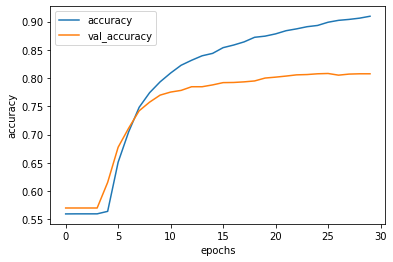

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

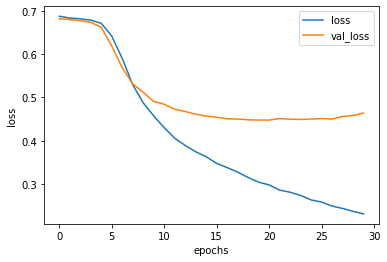

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

<u>드롭아웃이 손실 측면에서 긍정적인 효과</u>가 나타난다.   
벌어지고 있지만, 이전보다 가깝다.

## 4. RNN에 사전 훈련된 임베딩 사용하기

In [17]:
# ▼ GloVe 임베딩 가져오기
!wget https://bit.ly/3i9taLA -O glove.zip

UsageError: Line magic function `%wget` not found.


In [18]:
# ▼ GloVe 임베딩 압축 풀기
import os
import zipfile
local_zip = 'glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('glove')
zip_ref.close()

In [19]:
# ▼ glove_embeddings 변수에 각 단어에 대한 coef 값 가져오기
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]                                # 맨 앞은 단어
    coefs = np.asarray(values[1:], dtype='float32') # 그 뒤는 coef 값들
    glove_embeddings[word] = coefs                  # 단어를 key로 하는 딕셔너리 만들기
f.close()

In [20]:
# 예: key = 'frog'인 value 값(coef 값) 확인하기
glove_embeddings['frog']

array([-1.2158  , -0.74924 ,  0.91941 ,  0.72985 , -0.12917 , -0.19555 ,
        1.2365  , -0.77196 ,  0.85161 ,  0.11922 ,  0.16816 ,  0.33334 ,
       -2.0845  , -0.53471 ,  0.013538,  0.18178 ,  1.2831  ,  0.089331,
        0.57264 ,  0.50694 ,  0.27134 ,  0.66504 ,  0.54097 , -0.58377 ,
        0.67097 ], dtype=float32)

In [21]:
# ▼ 사전 설정
vocab_size = 13200      # vocab_size는 아래 말뭉치단어 중 CloVe에 몇개가 있는지 확인하고 나서 결정된 것.
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [22]:
# ▼ 훈련세트와 검증세트 분리
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [23]:
# ▼ 토큰화 실시
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

▼ 말뭉치에 있는 단어 중 얼마나 많은 단어가 CloVe 벡터에 있는지 확인하기

In [24]:
xs=[]
ys=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
    xs.append(index)
    if glove_embeddings.get(word) is not None:      # embedding에 있는 단어일 경우 ys에 1 추가하고 total_y에 1 더하기
        total_y = total_y + 1
        ys.append(1)
    else:
        ys.append(0)                                # 없는 경우 ys에 0 추가
    cumulative_y.append(total_y / index)            # cumulative_y 값을 지금까지 나온 단어로 나눠서 몇 퍼센트의 단어가 embedding에 있는지 확인

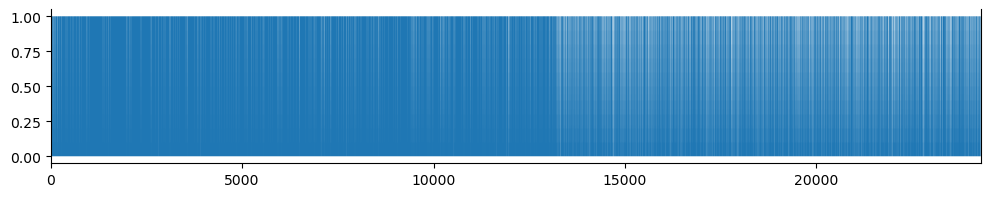

In [25]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)
plt.show()
# 1이면 파란색 0이면 흰색으로 표현된다.
# 10000~15000 사이에서 임베딩에 없는 단어의 빈도가 많아지는 것을 볼 수 있다.

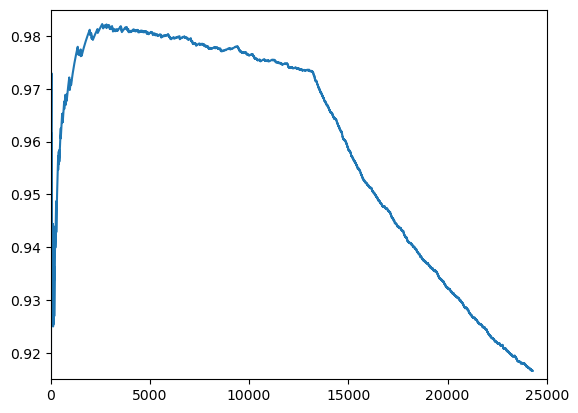

In [27]:
plt.plot(xs, cumulative_y)
plt.axis([0, 25000, .915, .985])
plt.show()

GloVe에 없는 단어가 많아지는 변곡점 = 13200으로 결정   

In [ ]:
# vocab_size 설정
vocab_size = 13200

In [28]:
# ▼ 생성한 어휘 사전의 단어들에 대해서만 GloVe 에서 뽑아서 임베딩 행렬 만들기
embedding_matrix = np.zeros((vocab_size, embedding_dim))        # (어휘 사전 크기 x 임베딩 차원 크기)의 0의 행렬을 만들어둔다.
for word, index in tokenizer.word_index.items():                # 어휘 사전에 있는 단어에 대해서
    if index > vocab_size - 1:                                  # 3.index 끝나면 break
        break
    else:
        embedding_vector = glove_embeddings.get(word)           # 1. GloVe 벡터를 찾아서
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector          # 2. 행렬에 추가

In [29]:
# ▼ np.array로 변환
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [30]:
# ▼ 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),         # weights의 매개변수로 위에서 전처리한 임베딩 벡터(= embedding_matrix) 사용
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [31]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 26s 30ms/step - loss: 0.6879 - accuracy: 0.5364 - val_loss: 0.6842 - val_accuracy: 0.5640
Epoch 2/30
719/719 [==============================] - 22s 31ms/step - loss: 0.6800 - accuracy: 0.5705 - val_loss: 0.6764 - val_accuracy: 0.5913
Epoch 3/30
719/719 [==============================] - 23s 32ms/step - loss: 0.6707 - accuracy: 0.6031 - val_loss: 0.6666 - val_accuracy: 0.6145
Epoch 4/30
719/719 [==============================] - 23s 33ms/step - loss: 0.6586 - accuracy: 0.6257 - val_loss: 0.6549 - val_accuracy: 0.6250
Epoch 5/30
719/719 [==============================] - 24s 33ms/step - loss: 0.6447 - accuracy: 0.6391 - val_loss: 0.6423 - val_accuracy: 0.6285
Epoch 6/30
719/719 [==============================] - 23s 33ms/step - loss: 0.6318 - accuracy: 0.6468 - val_loss: 0.6317 - val_accuracy: 0.6374
Epoch 7/30
719/719 [==============================] - 24s 33ms/step - loss: 0.6216 - accuracy: 0.6549 - val_loss: 0.6225 - val_accuracy:

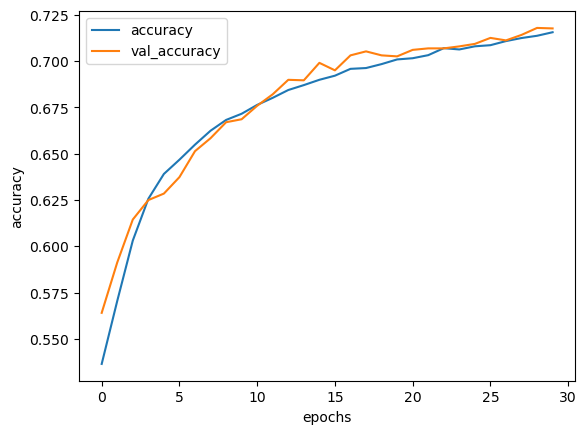

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

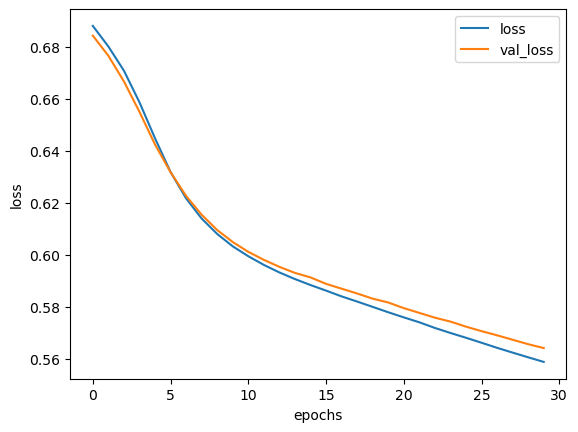

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

num_epochs = 150
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/150
719/719 [==============================] - 18s 17ms/step - loss: 0.6922 - accuracy: 0.5418 - val_loss: 0.6876 - val_accuracy: 0.5700
Epoch 2/150
719/719 [==============================] - 11s 16ms/step - loss: 0.6857 - accuracy: 0.5596 - val_loss: 0.6806 - val_accuracy: 0.5697
Epoch 3/150
719/719 [==============================] - 13s 18ms/step - loss: 0.6756 - accuracy: 0.5652 - val_loss: 0.6669 - val_accuracy: 0.5886
Epoch 4/150
719/719 [==============================] - 11s 16ms/step - loss: 0.6505 - accuracy: 0.6202 - val_loss: 0.6371 - val_accuracy: 0.6382
Epoch 5/150
719/719 [==============================] - 11s 15ms/step - loss: 0.6263 - accuracy: 0.6521 - val_loss: 0.6249 - val_accuracy: 0.6525
Epoch 6/150
719/719 [==============================] - 11s 16ms/step - loss: 0.6172 - accuracy: 0.6584 - val_loss: 0.6181 - val_accuracy: 0.6635
Epoch 7/150
719/719 [==============================] - 11s 16ms/step - loss: 0.6115 - accuracy: 0.6642 - val_loss: 0.6127 - val_ac

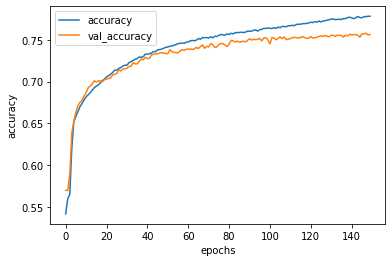

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

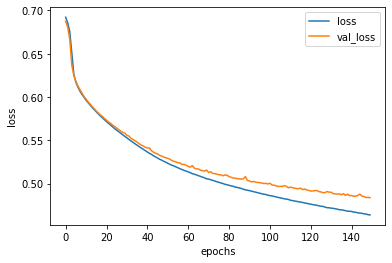

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [46]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

sequences = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
predictions = model.predict(padded)
print(predictions)

1/1 [==============================] - 1s 1s/step
[[0.79484975]
 [0.05374813]
 [0.90637976]
 [0.73468477]]
